In [ ]:
import zipfile

zip_path = "/content/archive.zip"
extract_path = "/content/face_Emotion"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzip complete")


Unzip complete


# Data set check

In [ ]:
import os

base_path = "/content/face_Emotion/DATASET"

for split in ["train", "test"]:
    print(f"\n {split.upper()} DATA")
    split_path = os.path.join(base_path, split)

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            print(cls, "→", len(os.listdir(cls_path)))



📂 TRAIN DATA
7 → 2524
2 → 281
3 → 717
6 → 705
1 → 1290
5 → 1982
4 → 4772

📂 TEST DATA
7 → 680
2 → 74
3 → 160
6 → 162
1 → 329
5 → 478
4 → 1185


# Data clening check

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import hashlib

base_path = "/content/face_Emotion/DATASET"
valid_ext = (".jpg", ".jpeg", ".png")

def is_blank(img):
    return np.mean(img) < 10

def is_blurry(img):
    return cv2.Laplacian(img, cv2.CV_64F).var() < 50

def get_hash(img_path):
    with open(img_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

report = {
    "non_image": 0,
    "corrupt": 0,
    "blank": 0,
    "blurry": 0,
    "duplicate": 0
}

for split in ["train", "test"]:
    print(f"\n CHECKING {split.upper()} DATA")
    split_path = os.path.join(base_path, split)

    hashes = set()

    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)

            # non-image
            if not img_name.lower().endswith(valid_ext):
                report["non_image"] += 1
                continue

            # corrupt
            try:
                Image.open(img_path).verify()
            except:
                report["corrupt"] += 1
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                report["corrupt"] += 1
                continue

            if is_blank(img):
                report["blank"] += 1
                continue

            if is_blurry(img):
                report["blurry"] += 1
                continue

            h = get_hash(img_path)
            if h in hashes:
                report["duplicate"] += 1
            else:
                hashes.add(h)

    print("Non-image files :", report["non_image"])
    print("Corrupt images :", report["corrupt"])
    print("Blank images   :", report["blank"])
    print("Blurry images  :", report["blurry"])
    print("Duplicate imgs :", report["duplicate"])



📂 CHECKING TRAIN DATA
Non-image files : 0
Corrupt images : 0
Blank images   : 0
Blurry images  : 684
Duplicate imgs : 2

📂 CHECKING TEST DATA
Non-image files : 0
Corrupt images : 0
Blank images   : 0
Blurry images  : 856
Duplicate imgs : 3


In [ ]:
import tensorflow as tf

base_path = "/content/face_Emotion/DATASET"
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_CLASSES = 7




# **image dataset load karta hai TensorFlow me**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_path + "/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="rgb",
    shuffle=True               # shuffle=False: Model pehle sirf angry, phir sirf happy, phir sirf sad images dekhega
                         #  shuffle=True: Model angry, happy, sad images ko mix karke random order me dekhega
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_path + "/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="rgb"
)


Found 12271 files belonging to 7 classes.
Found 3068 files belonging to 7 classes.


In [ ]:
import tensorflow as tf

print("Train len (batches):", tf.data.experimental.cardinality(train_ds).numpy())
print("Test len (batches) :", tf.data.experimental.cardinality(test_ds).numpy())


Train len (batches): 384
Test len (batches) : 96


In [ ]:
384*32

12288

In [ ]:
96*32

3072

## **Test data ko 50% test or 50%** **val** **kr** **diya** **bold text**

In [ ]:
n = tf.data.experimental.cardinality(test_ds).numpy()

val_ds = test_ds.take(n//2)            # image case me: head = take() aur tail = skip() kam krte he
final_test_ds = test_ds.skip(n//2)


In [ ]:
# shape check krte he images ka
for x_train, y_train in train_ds.take(1):
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)

for x_test, y_test in test_ds.take(1):
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

x_train shape: (32, 128, 128, 3)
y_train shape: (32,)
x_test shape: (32, 128, 128, 3)
y_test shape: (32,)


In [ ]:
x_train[0]

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[  3.      ,   8.      ,   4.      ],
        [  3.      ,   8.      ,   4.      ],
        [  3.      ,   8.      ,   4.      ],
        ...,
        [176.07812 , 136.07812 , 101.078125],
        [169.04688 , 129.04688 ,  94.046875],
        [163.      , 123.      ,  88.      ]],

       [[  3.671875,   8.671875,   4.671875],
        [  3.671875,   8.671875,   4.671875],
        [  3.671875,   8.671875,   4.671875],
        ...,
        [166.24146 , 126.91333 ,  93.99194 ],
        [157.85596 , 118.52783 ,  85.774414],
        [150.90625 , 111.578125,  77.921875]],

       [[  4.      ,   9.      ,   5.      ],
        [  4.      ,   9.      ,   5.      ],
        [  4.      ,   9.      ,   5.      ],
        ...,
        [145.125   , 108.390625,  78.5022  ],
        [136.82153 , 100.08716 ,  70.39209 ],
        [130.95312 ,  94.21875 ,  63.484375]],

       ...,

       [[154.53125 , 134.53125 , 125.53125 ],
        [154.

## **Normalization**

In [ ]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds   = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds  = test_ds.map(lambda x, y: (x / 255.0, y))


In [ ]:
#normalize value check
images, labels = next(iter(val_ds))
print(images[0, 0, 0, 0])


tf.Tensor(0.21960784, shape=(), dtype=float32)


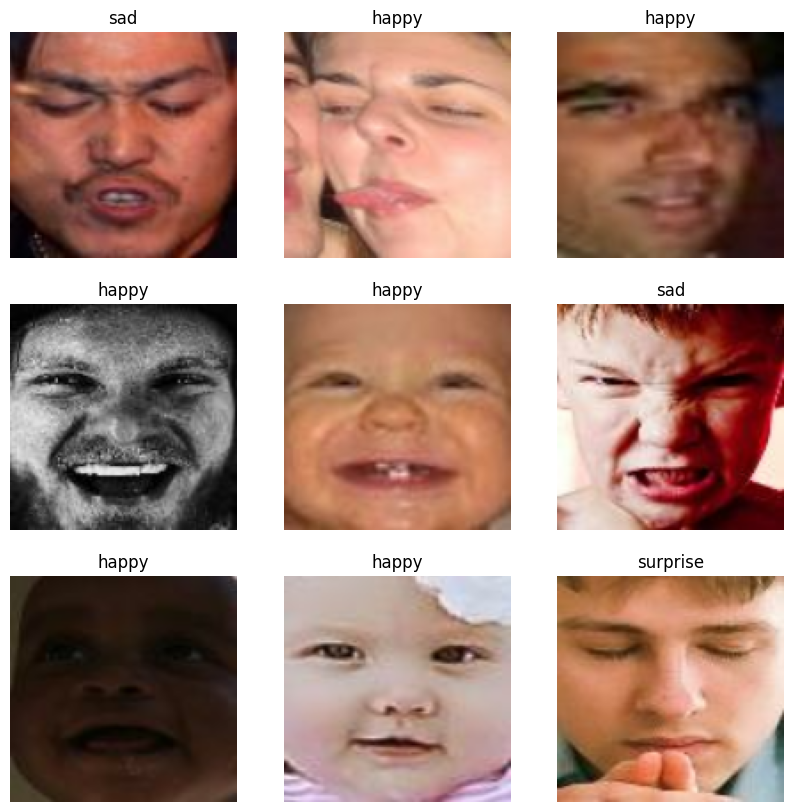

In [ ]:
import matplotlib.pyplot as plt

class_names = ['angry','disgust','fear','happy','neutral','sad','surprise']

images, labels = next(iter(train_ds))

plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i].numpy()])
    plt.axis("off")

plt.show()


# **Data Agumantation**

In [ ]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.07),
    tf.keras.layers.RandomZoom(0.07),
    tf.keras.layers.RandomContrast(0.07),   # optional
])


# **Modal** **Building**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


model = Sequential([
    data_aug,

    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(7, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Compile**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=0.0001,
        weight_decay=1e-4
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# **Early** **Stopping**

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Reduce LR on Plateau
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# **Train**

In [ ]:
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8368 - loss: 0.4840 - val_accuracy: 0.7722 - val_loss: 0.6480 - learning_rate: 1.0000e-06
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8286 - loss: 0.4880 - val_accuracy: 0.7699 - val_loss: 0.6488 - learning_rate: 1.0000e-06
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8357 - loss: 0.4828 - val_accuracy: 0.7709 - val_loss: 0.6456 - learning_rate: 1.0000e-06
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8335 - loss: 0.4898 - val_accuracy: 0.7715 - val_loss: 0.6466 - learning_rate: 1.0000e-06
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8324 - loss: 0.4918 - val_accuracy: 0.7699 - val_loss: 0.6460 - learning_rate: 1.0000e-06
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8388 - loss: 0.4784 - val_accuracy: 0.7712 - val_loss: 0.6476 - learning_rate: 1.0000e-06
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 6

In [ ]:
model.save('Face_Recognation_model1.keras')

**App.py file create**

In [1]:
%%writefile app.py
from flask import Flask, render_template, request, jsonify
import numpy as np
import tensorflow as tf
import cv2
import base64

# NEW SETUP (static + ngrok compatible)
app = Flask(__name__, static_folder="static")

emotion_labels = [
    'angry','disgust','fear',
    'happy','neutral','sad','surprise'
]

model = tf.keras.models.load_model("Face_Recognation_model1.keras")

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    data = request.json["image"]

    # base64 → image
    img_data = base64.b64decode(data.split(",")[1])
    np_img = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(np_img, cv2.IMREAD_COLOR)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    #  OLD BEHAVIOUR RESTORED (less strict, smooth)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,     # old feel (better realtime)
        minNeighbors=4,      # less strict
        minSize=(60, 60)     # door face bhi detect
    )

    # OLD LOGIC STYLE (no hard break)
    if len(faces) == 0:
        return jsonify({
            "status": "no_face",
            "message": "Face not detected"
        })

    #  ALWAYS USE FIRST FACE (old smooth behaviour)
    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    face = cv2.resize(face, (128,128))
    face = face / 255.0
    face = np.expand_dims(face, axis=0)

    preds = model.predict(face, verbose=0)[0]
    idx = np.argmax(preds)

    return jsonify({
        "status": "ok",
        "emotion": emotion_labels[idx],
        "confidence": float(preds[idx] * 100)
    })

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)


Writing app.py


In [2]:
!mkdir templates
!mkdir static

In [13]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Emotion Detection</title>

  <style>
    body {
      margin: 0;
      font-family: "Segoe UI", Arial, sans-serif;
      height: 100vh;

      background: linear-gradient(
          rgba(0,0,0,0.55),
          rgba(0,0,0,0.55)
        ),
        url("/static/web_background.png") center / cover no-repeat;

      display: flex;
      justify-content: center;
      align-items: center;
      color: #fff;
    }

    /* 🔹 RUNNING TEXT */
    .marquee {
      position: fixed;
      top: 0;
      width: 100%;
      overflow: hidden;
      background: rgba(0,0,0,0.7);
      z-index: 1000;
      padding: 10px 0;
      text-align: center;
    }

    .marquee span {
      display: inline-block;
      white-space: nowrap;
      font-size: 20px;
      font-weight: 500;
      color: #00ff99;
      animation: scroll 15s linear infinite;
    }

    @keyframes scroll {
      from { transform: translateX(100%); }
      to { transform: translateX(-100%); }
    }

    .app {
      display: flex;
      gap: 30px;
      align-items: center;
      margin-top: 60px; /* marquee space */
    }

    .emoji-panel {
      display: flex;
      flex-direction: column;
      gap: 15px;
      font-size: 34px;
    }

    .camera-card {
      position: relative;
      padding: 20px;
      border-radius: 18px;
      background: rgba(255,255,255,0.12);
      backdrop-filter: blur(12px);
      box-shadow: 0 15px 40px rgba(0,0,0,0.4);
      text-align: center;
    }

    h2 {
      margin-bottom: 10px;
      font-weight: 500;
    }

    #container {
      position: relative;
      display: inline-block;
    }

    video {
      border-radius: 12px;
    }

    canvas {
      position: absolute;
      left: 50%;
      transform: translateX(-50%);
      pointer-events: none;
      background: transparent;
    }

    #result {
      margin-top: 15px;
      font-size: 18px;
      font-weight: 500;
      min-height: 24px;
    }

    .info-panel {
      min-width: 220px;
      background: rgba(255,255,255,0.12);
      backdrop-filter: blur(10px);
      border-radius: 16px;
      padding: 18px;
      box-shadow: 0 15px 35px rgba(0,0,0,0.4);
    }

    .emotion-row {
      display: flex;
      justify-content: space-between;
      margin-bottom: 8px;
      font-size: 15px;
    }

    .info-panel:not(:first-of-type) {
      display: none !important;
    }
  </style>
</head>

<body>

  <!-- 🔹 RUNNING HEADING -->
  <div class="marquee">
    <span>Welcome to AFNANKHAN’s Web App — We’re Glad to Have You Here • Welcome to AFNANKHAN’s Web App — We’re Glad to Have You Here </span>
  </div>

  <div class="app">

    <div class="emoji-panel">
      😀
      😮
      😐
      😢
      😡
    </div>

    <div class="camera-card">
      <h2>Bring your face inside ⭕ the circle</h2>

      <div id="container">
        <video id="video" width="400" height="300" autoplay></video>
        <canvas id="overlay" width="400" height="300"></canvas>
      </div>

      <div id="result">Camera ready…</div>
    </div>

    <div class="info-panel">
      <h3>Emotion Probability</h3>
      <div class="emotion-row"><span>Happy</span><span>--%</span></div>
      <div class="emotion-row"><span>Surprise</span><span>--%</span></div>
      <div class="emotion-row"><span>Neutral</span><span>--%</span></div>
      <div class="emotion-row"><span>Sad</span><span>--%</span></div>
      <div class="emotion-row"><span>Angry</span><span>--%</span></div>
    </div>

  </div>

  <script>
    const video = document.getElementById("video");
    const canvas = document.getElementById("overlay");
    const ctx = canvas.getContext("2d");
    const resultDiv = document.getElementById("result");

    navigator.mediaDevices.getUserMedia({ video: true })
      .then(stream => video.srcObject = stream)
      .catch(() => resultDiv.innerText = "Camera access allow karo");

    function drawCircle() {
      ctx.clearRect(0, 0, canvas.width, canvas.height);
      ctx.beginPath();
      ctx.arc(canvas.width / 2, canvas.height / 2, 100, 0, 2 * Math.PI);
      ctx.strokeStyle = "lime";
      ctx.lineWidth = 3;
      ctx.stroke();
    }

    setInterval(drawCircle, 30);

    function captureAndPredict() {
      if (video.videoWidth === 0) return;

      const temp = document.createElement("canvas");
      temp.width = video.videoWidth;
      temp.height = video.videoHeight;
      temp.getContext("2d").drawImage(video, 0, 0);

      fetch("/predict", {
        method: "POST",
        headers: { "Content-Type": "application/json" },
        body: JSON.stringify({ image: temp.toDataURL("image/jpeg") })
      })
      .then(res => res.json())
      .then(data => {
        if (data.status === "ok") {
          resultDiv.innerHTML =
            `Emotion: <b>${data.emotion.toUpperCase()}</b><br>
             Confidence: ${data.confidence.toFixed(2)}%`;
        } else {
          resultDiv.innerHTML =
            `<span style="color:#ffcc00">The face is not being detected properly</span>`;
        }
      })
      .catch(() => {
        resultDiv.innerHTML =
          `<span style="color:#ff6666">Server error</span>`;
      });
    }

    setInterval(captureAndPredict, 2000);
  </script>

</body>
</html>


Overwriting templates/index.html


In [14]:
!ls


app.py	Face_Recognation_model1.keras  logs.txt  sample_data  static  templates


In [15]:
!pkill ngrok

In [5]:
!pip install pyngrok


In [16]:
!ngrok config add-authtoken 2xFzrqv0DqljwNSEL7GTsiExZgz_6nqyZcnsa5agW9kCN5cBj
!python app.py &>/content/logs.txt &

from pyngrok import ngrok

ngrok.kill()
public_url = ngrok.connect(5000)
print("🌐 Flask App URL:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Flask App URL: NgrokTunnel: "https://5adadc579bb5.ngrok-free.app" -> "http://localhost:5000"
